# Lab-01: Building and evaluating Q&A applications using Titan and Cohere Embedded Knowledge Bases with Ragas

### Context

In this notebook, we will dive deep into building Q&A applications using the Retrieve API provide by Knowledge Bases for Amazon Bedrock, along with LangChain and Ragas for evaluating the responses. Here, we will query the knowledge base to get the desired number of document chunks based on similarity search, prompt the query using Anthropic Claude, and then evaluate the responses effectively using evaluation metrics, such as faithfulness, answer_relevancy, context_recall, context_precision, context_entity_recall, answer_similarity, answer_correctness, harmfulness, maliciousness, coherence, correctness and conciseness.

### Knowledge Bases for Amazon Bedrock Introduction

With knowledge bases, you can securely connect foundation models (FMs) in Amazon Bedrock to your company
data for Retrieval Augmented Generation (RAG). Access to additional data helps the model generate more relevant,
context-speciﬁc, and accurate responses without continuously retraining the FM. All information retrieved from
knowledge bases comes with source attribution to improve transparency and minimize hallucinations. For more information on creating a knowledge base using console, please refer to this [post](!https://docs.aws.amazon.com/bedrock/latest/userguide/knowledge-base.html).

### Pattern

We can implement the solution using Retrieval Augmented Generation (RAG) pattern. RAG retrieves data from outside the language model (non-parametric) and augments the prompts by adding the relevant retrieved data in context. Here, we are performing RAG effectively on a knowledge base we will create as part of this lab. 

<!-- ![data_ingestion.png](./images/data_ingestion.png) -->
<img src="./assets/data_ingestion.png" width=50% height=20% />


#### Notebook Walkthrough



For our notebook we will use the `Retrieve API` provided by Knowledge Bases for Amazon Bedrock which converts user queries into
embeddings, searches the knowledge base, and returns the relevant results, giving you more control to build custom
workﬂows on top of the semantic search results. The output of the `Retrieve API` includes the the `retrieved text chunks`, the `location type` and `URI` of the source data, as well as the relevance `scores` of the retrievals. 


We will then use the text chunks being generated and augment it with the original prompt and pass it through the `anthropic.claude-3-haiku-20240307-v1:0` model.

Finally we will evaluate the generated responses using RAGAS on using metrics such as faithfulness, answer relevancy,and context precision. For evaluation, we will use `anthropic.claude-3-haiku-20240307-v1:0`.
### Ask question


<!-- ![retrieveapi.png](./images/retrieveAPI.png) -->
<img src="./assets/retrieveAPI.png" width=50% height=20% />
    

### USE CASE:

#### Dataset

In this example, you will use Octank's financial 10k reports (sythetically generated dataset) as a text corpus to perform Q&A on. This data will be ingested into the knowledge base.

### Python 3.10

⚠  For this lab we need to run the notebook based on a Python 3.10 runtime. ⚠

## Download data to ingest into our knowledge base.
We'll use the following data:

* example financial statement documents of fake company "Octank"

### Upload data to S3 Bucket data source

In [ ]:
!python -m pip install --upgrade pip


In [ ]:
!pip install certifi

In [ ]:
!pip install opensearch-py

In [2]:
!pip uninstall pydantic -y

Found existing installation: pydantic 2.11.2
Uninstalling pydantic-2.11.2:
  Successfully uninstalled pydantic-2.11.2


In [3]:
!pip install pydantic==1.7.* 

  Using cached pydantic-1.7.4-py3-none-any.whl.metadata (85 kB)
Using cached pydantic-1.7.4-py3-none-any.whl (107 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-scheduler 2.7.1 requires pydantic<3,>=1.10, but you have pydantic 1.7.4 which is incompatible.
langfuse 2.60.2 requires pydantic<3.0,>=1.10.7, but you have pydantic 1.7.4 which is incompatible.
openai 1.70.0 requires pydantic<3,>=1.9.0, but you have pydantic 1.7.4 which is incompatible.
ragas 0.2.14 requires pydantic>=2, but you have pydantic 1.7.4 which is incompatible.
sagemaker-jupyterlab-extension-common 0.1.21 requires pydantic<3,>=1.10.17, but you have pydantic 1.7.4 which is incompatible.


In [1]:
!pip show pydantic

Name: pydantic
Version: 1.7.4
Summary: Data validation and settings management using python 3.6 type hinting
Home-page: https://github.com/samuelcolvin/pydantic
Author: Samuel Colvin
Author-email: s@muelcolvin.com
License: MIT
Location: /opt/conda/lib/python3.10/site-packages
Requires: 
Required-by: amazon_sagemaker_jupyter_scheduler, confection, fastapi, gluonts, jupyter_scheduler, langchain, langchain-core, langfuse, langsmith, openai, ragas, sagemaker-jupyterlab-extension-common, spacy, thinc, weasel


In [2]:
!pip install ragas -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gluonts 0.13.7 requires pydantic~=1.7, but you have pydantic 2.11.2 which is incompatible.


In [ ]:
# %load_ext autoreload
# %autoreload 2

In [3]:
import logging
logging.getLogger("sagemaker.config").setLevel(logging.WARNING)
import sagemaker
import boto3
import pprint
from botocore.client import Config

pp = pprint.PrettyPrinter(indent=2)
# Specify your bucket to be the default sagemaker bucket
sess = sagemaker.Session()
bucket = sess.default_bucket() #sagemaker-abcdef
filename = 'octank_financial_10K.pdf'

# Create an S3 client
s3 = boto3.client('s3')

# Upload the file
s3.upload_file(filename, bucket, filename)
print("Upload Successful!!\n")
print(f"{filename} was successfully uploaded to {bucket}/{filename}")

Upload Successful!!

octank_financial_10K.pdf was successfully uploaded to sagemaker-us-east-1-058264176820/octank_financial_10K.pdf


## Create Knowledge Base

We have abstracted much of the knowledge base creation from this lab into the below.

In [4]:
import json
import boto3
from utility import interactive_sleep, create_knowledge_base, create_ds
from concurrent.futures import ThreadPoolExecutor

boto3_session = boto3.session.Session()
region_name = boto3_session.region_name

def create_amazon_titan_knowledge_base():
    return create_knowledge_base(
        index_name="amazon-titan-embedding-v2",
        collection_name="amazon-titan-embedding-v2",
        knowledge_base_name="amazon-titan-embedding-v2",
        vector_store_name="amazon-titan-embedding-v2",
        access_policy_name="amazon-titan-access-policy",
        embedding_model_arn=f"arn:aws:bedrock:{region_name}::foundation-model/amazon.titan-embed-text-v2:0"
    )

def create_cohere_embed_knowledge_base():
    return create_knowledge_base(
        index_name="cohere-embed-english-v3",
        collection_name="cohere-embed-english-v3",
        knowledge_base_name="cohere-embed-english-v3",
        vector_store_name="cohere-embed-english-v3",
        access_policy_name="cohere-embed-access-policy",
        embedding_model_arn=f"arn:aws:bedrock:{region_name}::foundation-model/cohere.embed-english-v3"
    )


with ThreadPoolExecutor(max_workers=2) as executor:
    amazon_titan_future = executor.submit(create_amazon_titan_knowledge_base)
    cohere_embed_future = executor.submit(create_cohere_embed_knowledge_base)
    
    amazon_titan_knowledge_base = amazon_titan_future.result()
    cohere_embed_knowledge_base = cohere_embed_future.result()

# interactive_sleep(30)
print(f"Amazon Titan Knowledge Base Id: {amazon_titan_knowledge_base['knowledgeBaseId']}")
print(f"Cohere Embed Knowledge Base Id: {cohere_embed_knowledge_base['knowledgeBaseId']}")

bedrock kb execution role arn:aws:iam::058264176820:role/amazon-sagemaker-base-executionrole
bedrock kb execution role arn:aws:iam::058264176820:role/amazon-sagemaker-base-executionrole
Amazon Titan Knowledge Base Id: QAMHHNPK7K
Cohere Embed Knowledge Base Id: O079GGLKHW


### Link Data Sources and Sync


Determine chunking strategy, based on which KB will split the documents into pieces of size equal to the chunk size mentioned in the chunkingStrategyConfiguration.

NOTE: In the current sample, we'll use FIXED_SIZE chunking strategy

<img src="./assets/fixed_chunking.png" width=50% height=20% />

In [5]:
chunkingStrategyConfiguration = {
    "chunkingStrategy": "FIXED_SIZE", 
    "fixedSizeChunkingConfiguration": {
        "maxTokens": 300,
        "overlapPercentage": 20
    }
}

def create_data_source(knowledgeBaseId):
    return create_ds(chunkingStrategyConfiguration, knowledgeBaseId, bucket)

with ThreadPoolExecutor(max_workers=2) as executor:
    amazon_titan_data_source_future = executor.submit(create_data_source, amazon_titan_knowledge_base['knowledgeBaseId'])
    cohere_embed_data_source_future = executor.submit(create_data_source, cohere_embed_knowledge_base['knowledgeBaseId'])

    amazon_titan_data_source = amazon_titan_data_source_future.result()
    cohere_embed_data_source = cohere_embed_data_source_future.result()
    
interactive_sleep(30) ## we need to wait a little bit after the data sources finish syncing for them to be available
print("Done!")

Starting syncing job for Knowledge Base ID: QAMHHNPK7K

Starting syncing job for Knowledge Base ID: O079GGLKHW

Sync job for Knowledge Base ID: QAMHHNPK7K complete

Sync job for Knowledge Base ID: O079GGLKHW complete

Done!.........................


In [6]:
kbs = [amazon_titan_knowledge_base, cohere_embed_knowledge_base] 
print(kbs)

[{'knowledgeBaseId': 'QAMHHNPK7K', 'name': 'amazon-titan-embedding-v2-knowledge-base', 'status': 'ACTIVE', 'updatedAt': datetime.datetime(2025, 4, 7, 1, 28, 37, 692872, tzinfo=tzlocal())}, {'knowledgeBaseId': 'O079GGLKHW', 'name': 'cohere-embed-english-v3-knowledge-base', 'status': 'ACTIVE', 'updatedAt': datetime.datetime(2025, 4, 7, 1, 28, 37, 555153, tzinfo=tzlocal())}]


### Follow the steps below to set up necessary packages

1. Import the necessary libraries for creating `bedrock-runtime` for invoking foundation models and `bedrock-agent-runtime` client for using Retrieve API provided by Knowledge Bases for Amazon Bedrock. 
2. Import Langchain for: 
   1. Initializing bedrock model  `anthropic.claude-3-haiku-20240307-v1:0` as our large language model to perform query completions using the RAG pattern. 
   2. Initializing bedrock model  `anthropic.claude-3-haiku-20240307-v1:0` as our large language model to perform RAG assessment. 
3. Create a `AmazonKnowledgeBasesRetriever` object from LangChain which will call the `Retrieve API` provided by Knowledge Bases for Amazon Bedrock which converts user queries into embeddings, searches the knowledge base, and returns the relevant results, giving you more control to build custom workﬂows on top of the semantic search results.

In [7]:
from langchain.llms.bedrock import Bedrock
from langchain.retrievers.bedrock import AmazonKnowledgeBasesRetriever
from langchain.chains import RetrievalQA
from langchain_aws import BedrockEmbeddings
from langchain_aws import ChatBedrock


bedrock_config = Config(connect_timeout=120, read_timeout=120, retries={'max_attempts': 10})
bedrock_runtime_client = boto3.client('bedrock-runtime', config=bedrock_config)


kbs = [amazon_titan_knowledge_base, cohere_embed_knowledge_base] 

kwargs = {
    "temperature": 0
}

llm_for_text_generation = ChatBedrock(model_id="anthropic.claude-3-haiku-20240307-v1:0", client=bedrock_runtime_client, model_kwargs=kwargs)

llm_for_evaluation = ChatBedrock(model_id="anthropic.claude-3-haiku-20240307-v1:0", client=bedrock_runtime_client, model_kwargs=kwargs)

bedrock_embeddings = [ BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0",client=bedrock_runtime_client), BedrockEmbeddings(model_id="cohere.embed-english-v3",client=bedrock_runtime_client)]

print("LLM Clients created!!")

# Create two retrievers with the knowledge base IDs
retrievers = [
    AmazonKnowledgeBasesRetriever(
        knowledge_base_id=kb['knowledgeBaseId'],
        retrieval_config={"vectorSearchConfiguration": {"numberOfResults": 5}},
        # endpoint_url=endpoint_url,
        # region_name="us-east-1",
        # credentials_profile_name="<profile_name>",
    )
    for kb in kbs
]
print("Retrievers created!!")

LLM Clients created!!
Retrievers created!!


### Model Invocation and Response Generation using RetrievalQA chain 

Invoke the model and visualize the response

Question = `What was the primary reason for the increase in net cash provided by operating activities for Octank Financial in 2021?"`

Ground truth answer = 
```
According to the information provided, the primary reason for the increase in net cash provided by operating activities for Octank Financial in 2021 was:

An increase in net income and favorable changes in operating assets and liabilities.
...
```

In [8]:
query = "What was the primary reason for the increase in net cash provided by operating activities for Octank Financial in 2021?"

for retriever in retrievers:
    qa_chain = RetrievalQA.from_chain_type(
    llm=llm_for_text_generation, retriever=retriever, return_source_documents=True
    )
    response = qa_chain.invoke(query)
    print(f"KB: {retriever.knowledge_base_id} \n")
    print(f"{response['result']}\n\n")

KB: QAMHHNPK7K 

According to the information provided, the primary reason for the increase in net cash provided by operating activities for Octank Financial in 2021 was an increase in net income and favorable changes in operating assets and liabilities.

The statement says: "The increase in net cash provided by operating activities was primarily due to an increase in net income and favorable changes in operating assets and liabilities."


KB: O079GGLKHW 

According to the information provided, the primary reason for the increase in net cash provided by operating activities for Octank Financial in 2021 was:

"The increase in net cash provided by operating activities was primarily due to an increase in net income and favorable changes in operating assets and liabilities."




## Preparing the Evaluation Data

As Ragas aims to be a reference-free evaluation framework, the required preparations of the evaluation dataset are minimal. You will need to prepare `question` and `ground_truths` pairs from which you can prepare the remaining information through inference as shown below.

In [9]:
from datasets import Dataset

questions = [
    "What was the primary reason for the increase in net cash provided by operating activities for Octank Financial in 2021?",
    "In which year did Octank Financial have the highest net cash used in investing activities, and what was the primary reason for this?",
    "What was the primary source of cash inflows from financing activities for Octank Financial in 2021?"
]

prefix = "Keep your answers under 2000 characters in length. Only use information you are sure about from the knowledge base. "
questions = [prefix + question for question in questions]

ground_truth = [
    "The increase in net cash provided by operating activities was primarily due to an increase in net income and favorable changes in operating assets and liabilities.",
    "Octank Financial had the highest net cash used in investing activities in 2021, at $360 million, compared to $290 million in 2020 and $240 million in 2019. The primary reason for this was an increase in purchases of property, plant, and equipment and marketable securities.",
    "The primary source of cash inflows from financing activities for Octank Financial in 2021 was an increase in proceeds from the issuance of common stock and long-term debt."
]

def execute_rag(retriever):
    answers = []
    contexts = []
    kb_id = retriever.knowledge_base_id
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm_for_text_generation, retriever=retriever, return_source_documents=True
    )
    print(f"Answering questions for kb_id: {kb_id}...")
    for query in questions:
        response = qa_chain.invoke(query)
        answers.append(response["result"])
        contexts.append([docs.page_content for docs in response["source_documents"]])
    # To dict
    data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truth
    }
    return kb_id, data

datasets = {}
for retriever in retrievers:
    kb_id, data = execute_rag(retriever)
    datasets[kb_id] = Dataset.from_dict(data)

print("Questions answered and datasets created!!")

Answering questions for kb_id: QAMHHNPK7K...
Answering questions for kb_id: O079GGLKHW...
Questions answered and datasets created!!


## Evaluating the RAG application
<!-- ![RAGAS_Flow.png](./images/RAGAS_Flow.png) -->
<img src="./assets/RAGAS_Flow.png" width=50% height=20% />

First, import all the metrics you want to use from `ragas.metrics`. Then, you can use the `evaluate()` function and simply pass in the relevant metrics and the prepared dataset.

#### Evaluation
Utilize RAGAS for evaluation on:

1. **Faithfulness:** This measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. The answer is scaled to (0,1) range. Higher the better.

2. **Answer Relevance:** The evaluation metric, Answer Relevancy, focuses on assessing how pertinent the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information and higher scores indicate better relevancy. This metric is computed using the question, the context and the answer. Please note, that eventhough in practice the score will range between 0 and 1 most of the time, this is not mathematically guaranteed, due to the nature of the cosine similarity ranging from -1 to 1.

3. **Context Precision:** Context Precision is a metric that evaluates whether all of the ground-truth relevant items present in the contexts are ranked higher or not. Ideally all the relevant chunks must appear at the top ranks. This metric is computed using the question, ground_truth and the contexts, with values ranging between 0 and 1, where higher scores indicate better precision.

4. **Context Recall:** Context recall measures the extent to which the retrieved context aligns with the annotated answer, treated as the ground truth. It is computed based on the ground truth and the retrieved context, and the values range between 0 and 1, with higher values indicating better performance.
    
5. **Context entities recall:** This metric gives the measure of recall of the retrieved context, based on the number of entities present in both ground_truths and contexts relative to the number of entities present in the ground_truths alone. Simply put, it is a measure of what fraction of entities are recalled from ground_truths. This metric is useful in fact-based use cases like tourism help desk, historical QA, etc. This metric can help evaluate the retrieval mechanism for entities, based on comparison with entities present in ground_truths, because in cases where entities matter, we need the contexts which cover them.
    
6. **Answer Semantic Similarity:** The concept of Answer Semantic Similarity pertains to the assessment of the semantic resemblance between the generated answer and the ground truth. This evaluation is based on the ground truth and the answer, with values falling within the range of 0 to 1. A higher score signifies a better alignment between the generated answer and the ground truth.
    
7. **Answer Correctness:** The assessment of Answer Correctness involves gauging the accuracy of the generated answer when compared to the ground truth. This evaluation relies on the ground truth and the answer, with scores ranging from 0 to 1. A higher score indicates a closer alignment between the generated answer and the ground truth, signifying better correctness. Answer correctness encompasses two critical aspects: semantic similarity between the generated answer and the ground truth, as well as factual similarity. These aspects are combined using a weighted scheme to formulate the answer correctness score. Users also have the option to employ a ‘threshold’ value to round the resulting score to binary, if desired.
    
8. **Aspect Critique:** This is designed to assess submissions based on predefined aspects such as harmlessness and correctness. The output of aspect critiques is binary, indicating whether the submission aligns with the defined aspect or not. This evaluation is performed using the ‘answer’ as input.

In [10]:
from ragas import evaluate, RunConfig
from ragas.metrics import (
    answer_relevancy,
    context_recall,
    context_precision,
    context_entity_recall,
    answer_similarity,
    answer_correctness
)

#specify the metrics here
metrics = [
        answer_relevancy,
        context_precision,
        context_recall,
        context_entity_recall,
        answer_similarity,
        answer_correctness
    ]

def evaluate_kb(kb, embeddings, datasets, llm_for_evaluation):
    kb_id = kb['knowledgeBaseId']
    result = evaluate(
        dataset=datasets[kb_id],
        metrics=metrics,
        llm=llm_for_evaluation,
        embeddings=embeddings,
        run_config=RunConfig(max_workers=2)

    )
    return kb_id, result.to_pandas()

dfs = {}
for i, kb in enumerate(kbs):
    kb_id, df = evaluate_kb(kb, bedrock_embeddings[i], datasets, llm_for_evaluation)
    dfs[kb_id] = df

print("Ragas evaluation complete!!")
# disregard any "failed to parse output" errors. Those originate from the Ragas library

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Ragas evaluation complete!!


In [12]:
print(dfs)

{'QAMHHNPK7K':                                           user_input  \
0  Keep your answers under 2000 characters in len...   
1  Keep your answers under 2000 characters in len...   
2  Keep your answers under 2000 characters in len...   

                                  retrieved_contexts  \
0  [. The statement is divided into three main pa...   
1  [. The statement is divided into three main pa...   
2  [. The statement is divided into three main pa...   

                                            response  \
0  According to the information provided, the pri...   
1  According to the information provided:\n\nIn 2...   
2  According to the information provided, the pri...   

                                           reference  answer_relevancy  \
0  The increase in net cash provided by operating...          0.721290   
1  Octank Financial had the highest net cash used...          0.543380   
2  The primary source of cash inflows from financ...          0.687708   

   context_pr

Below we will plot the results:

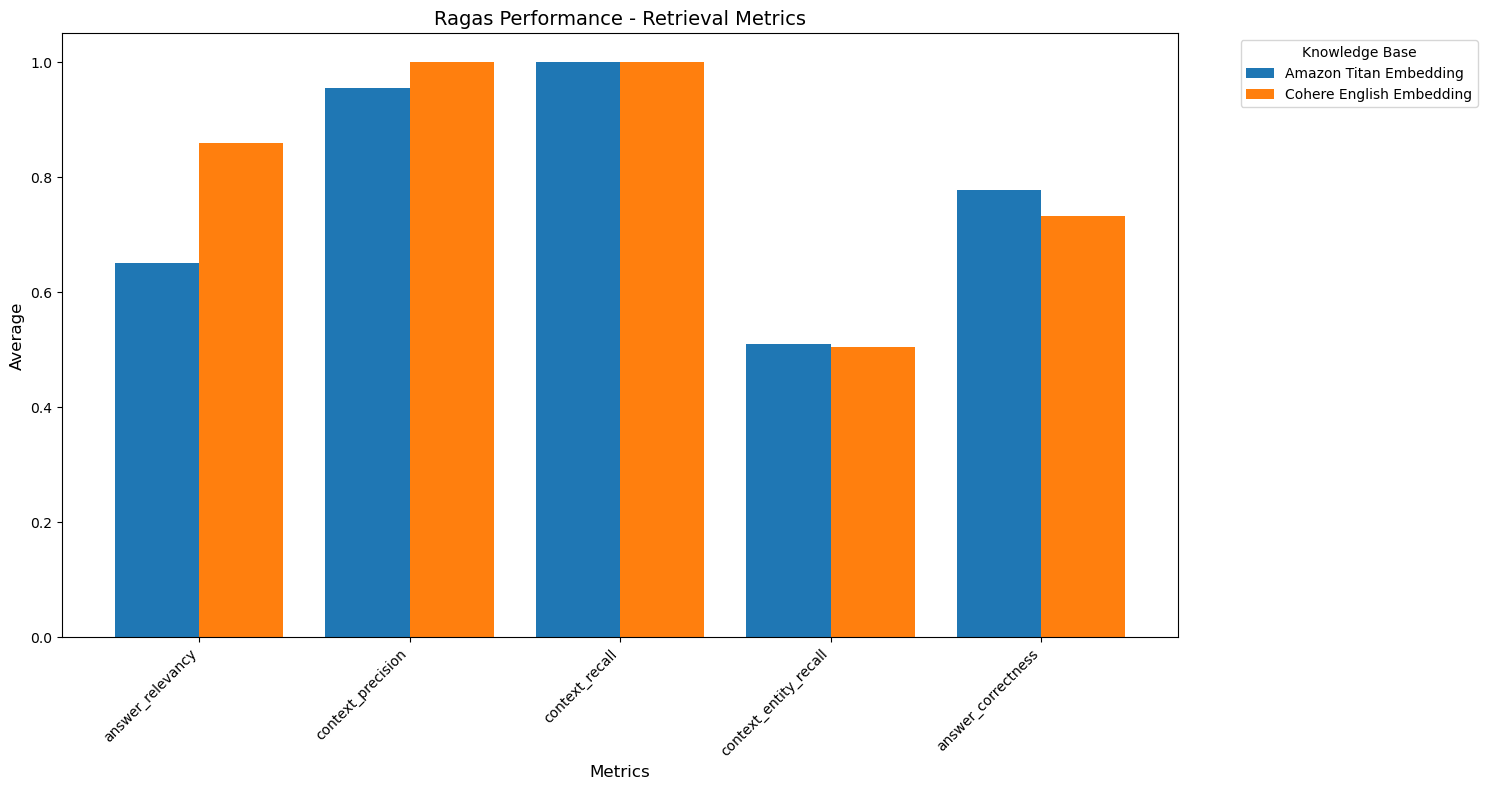

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = ['answer_relevancy', 'context_precision', 'context_recall',
                'context_entity_recall',  'answer_correctness']

# Create a mapping for display names
display_names = {
    'amazon-titan-embedding-v2-knowledge-base': 'Amazon Titan Embedding',
    'cohere-embed-english-v3-knowledge-base': 'Cohere English Embedding'
}

# Calculate the mean of numeric columns for each DataFrame
means = []
kb_names = []
for key, df in dfs.items():
    mean_values = df[numeric_cols].mean()
    means.append(mean_values)
    
    # Find the corresponding KB name from the 'kbs' list
    kb_name = next((kb['name'] for kb in kbs if kb['knowledgeBaseId'] == key), 'Unknown')
    kb_names.append(kb_name)

# Combine the means into a single DataFrame
means_df = pd.DataFrame(means, columns=numeric_cols, index=kb_names)

# Map the index to display names
means_df.index = means_df.index.map(display_names)

subset1 = means_df.iloc[:, :6]
plot_df1 = subset1.T

fig1, ax1 = plt.subplots(figsize=(15, 8))
plot_df1.plot(kind='bar', ax=ax1, width=0.8)

ax1.set_title('Ragas Performance - Retrieval Metrics', fontsize=14)
ax1.set_xlabel('Metrics', fontsize=12)
ax1.set_ylabel('Average', fontsize=12)
plt.xticks(rotation=45, ha='right')
ax1.legend(title='Knowledge Base', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

> Note: Please note the scores above gives a relative idea on the performance of your RAG application and should be used with caution and not as standalone scores. Also note, that we have used only 3 question/answer pairs for evaluation, as best practice, you should use enough data to cover different aspects of your document for evaluating model.

Based on the scores, you can review other components of your RAG workflow to further optimize the scores, few recommended options are to review your chunking strategy, prompt instructions, adding more numberOfResults for additional context and so on. 